# Logistic regression model with tabular data

- Predicting ICU mortality rate based on ICU tabular data
- Dataset: MIMIC III
- References: CSC2541 Machine learning for health, University of Toronto

## A. Set up

### A.1 Loading dataset
- Load ICU tabular dataset from MIMIC III (https://mimic.physionet.org/) 

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv('../examples/adult_icu.csv')
# df.head()

### A.2 Loading variables

In [5]:
non_features_list = ['subject_id', 'hadm_id', 'icustay_id', 'train', 'mort_icu', 'adult_icu']
features_list = np.asarray(df.columns)
features_list = [feature for feature in features_list if feature not in non_features_list] # all feature columsn

label_col = "mort_icu"

## B. Data Splits

In [6]:
from sklearn.model_selection import train_test_split

def run_data_split(df: pd.DataFrame):
    """
    Get train and test data frames using stratified splitting

    Inputs:
    - df: dataframe of all songs and corresponding features 

    Outputs: 
    - train_df: dataframe of songs and corresponding features in train split
    - test_df: dataframe of songs and corresponding features in test split
    - y_train: labels (song genre) of data points in train_df
    - y_test: labels (song genre) of data points in test_df
    """

    # get train test split by index value
        # stratified by label 
    idx_train, idx_test, y_train, y_test = train_test_split(df.index, df[label_col].values, test_size=0.33,random_state=109)

    # get train and test df
    train_df = df.iloc[idx_train]
    test_df = df.iloc[idx_test]

    return train_df, test_df, y_train, y_test

In [7]:
train_df, test_df, y_train, y_test = run_data_split(df)

print("Train= x: " + str(train_df.shape) + " , y: " + str(y_train.shape))
print("Test= x: " + str(test_df.shape) + " , y: " + str(y_test.shape))

Train= x: (18323, 62) , y: (18323,)
Test= x: (9025, 62) , y: (9025,)


## C. Data processing 



### C.1 Feature scaling 


https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Scaling features:
- purpose: Having features on a similar scale can help the gradient descent converge more quickly towards the minima.
- distance based algorithms: we scale our data before employing a distance based algorithm so that all the features contribute equally to the result. 

Types of scalers:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- StandardScaler: removes the mean and scales the data to unit variance
    - outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values
    - cannot guarantee balanced feature scales in the presence of outliers
- minmax scaler: normalizing to [0,1], sensitive to outliers
- maxabs scaler: absolute values scaled to [0,1], sensitive to outliers
- robust scaler: the centering and scaling statistics based on percentiles
    - not influenced by a few number of very large marginal outliers. 
    - resulting range of the transformed feature values is larger and are approximately similar. 
    - Outliers themselves are still present in the transformed data
- power transformer: applies a power transformation to each feature to make the data more Gaussian-like. 
    - Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms
    -  finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation

- QuantileTransformer: 
    - has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values
    - also can apply a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1], even the outliers which cannot be distinguished anymore from the inliers
    - robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

- normalizer:
    - rescales the vector for each sample to have unit norm, independently of the distribution of the samples


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

def fit_scaler(train_df, features_list: list, scale_type: str):
    """
    Fit scaler on train data
    note: scalers takes input (num_samples, num_features) and scales all features in features_list

    Inputs:
    - train_df: dataframe of x train data
    - features_list: list of features to be scaled
    - scale_type: type of scale to use (ie. standardize, normalize)

    Outputs: 
    scaler: scaler of interest, fitted on train data containing features from features_list
    """

    scaler_dict = {
        "standard" : StandardScaler(), 
        "minmax" : MinMaxScaler(feature_range=(0, 1)) , 
        "maxabs" : MaxAbsScaler(), 
        "robust": RobustScaler(quantile_range=(25, 75)),
        "power_yeo_johnson": PowerTransformer(method='yeo-johnson'),
        "power_box_cox" : PowerTransformer(method='box-cox'),
        "quartile_normal":  QuantileTransformer(output_distribution='normal'),
        "quartile_uniform": QuantileTransformer(output_distribution='uniform'),
        "normalizer": Normalizer()
    }
    
    scaler = scaler_dict[scale_type].fit(train_df[features_list])

    return scaler

In [9]:
# All non-binary features need to be standardized
binary_features = ['subject_id', 'hadm_id', 'icustay_id', 'mort_icu', 'first_icu_stay', 'first_hosp_stay', 'adult_icu', 'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other','eth_white', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN', 'admType_URGENT', 'admType_ELECTIVE', 'train', 'chartext']

# Get all feature columns that are non-binary
nonbinary_features = [feature for feature in features_list if feature not in binary_features]
print("Non binary features that are standardized: " + str(nonbinary_features))

# Fit the standardized scaler on the TRAIN data
scaler = fit_scaler(train_df, nonbinary_features, "standard")

# Tranform both TRAIN and TEST data on the scaler fitted on TRAIN data
train_df[nonbinary_features] = scaler.transform(train_df[nonbinary_features])
test_df[nonbinary_features] = scaler.transform(test_df[nonbinary_features])

# train_df.head()

Non binary features that are standardized: ['age', 'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc']


### C.2 Removing highly correlated features: (multicollinearity)
- https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
- https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
- Regression models:
    - assume features are uncorrelated
    - if features are correlated, this can lead to great instability in prediction 
    - model may not be particularly stable against small variations in the training set, because different weight vectors will have similar outputs
- random forrests:
    - generally immune to multicollinearity
    - highly correlated features can mask interactions between features

- Occam Razors:
    - simpler model is more preferable 
    - if features are highly correlated, they give the same information. Therefore you should just keep one feature and drop the rest 
    
- model runs faster with less features

code references: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/


In [10]:
def remove_highly_correlated_features(df: pd.DataFrame, features_list:list, non_features_list: list, threshold=0.95):
    """
    Remove features that are more correlated than 0.95
    - Remaining features should not be correlated by more than 0.95 with each other
    """

    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
        # np.triu = upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    to_keep = [f for f in features_list if f not in to_drop]

    print("Dropped features = " , to_drop)
    return df[non_features_list + to_keep], np.asarray(to_keep)


In [11]:
train_df, features_list = remove_highly_correlated_features(train_df, features_list, non_features_list)
test_df = test_df[non_features_list + list(features_list)]

# train_df.head()

Dropped features =  ['glucose_mean', 'hemoglobin']


### C.3 Obtain X_TRAIN, Y_TRAIN, X_TEST, Y_TEST

In [12]:
def format_data(df: pd.DataFrame, features_list: list, label_col="mort_icu"):
    """
    Format data for logistic regression

    Inputs:
    - df: dataframe of data
    - features_list: features of interest
    - idxs: indexes that match label

    Outputs:
    - data: np array of data (num_datapoints, num_features)
    - label: label corresponding to data
    """
    num_data = len(df)
    num_features = len(features_list)
    data = df[features_list].values.reshape(num_data, num_features)
    label = df[label_col].values.reshape(num_data,)

    return data, label

In [13]:
X_train, y_train = format_data(train_df, features_list)
X_test, y_test = format_data(test_df, features_list)

print("x train: " + str(X_train.shape))
print("y train: " + str(y_train.shape))
print("x train: " + str(X_test.shape))
print("y train: " + str(y_test.shape))

x train: (18323, 54)
y train: (18323,)
x train: (9025, 54)
y train: (9025,)


## D. Logistic regression

### D.1 Feature selection

- https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

- https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2

- Note the difference between linear and non-linear feature selection methods:
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6428288/
    - if features have non-linear relationship with label, linear feature selection methods will fail to capture these

1. Filter method:
- filter and take only the subset of relevant features (ie. model built AFTER selecting features)

1.1) Correlation:
- for linear models only
- based on correlation matrix (eg. pearson correlation)
    - check correlation of feature to label
    - only choose features with correlation greater than 0.5
- note: some models (eg. linear regression) assumes that independent variables are uncorrelated with each other
    - you should check that selected variables are uncorrelated with each other (ie. greater than 0.5), and select only 1 from the group
- overall good for EDA, but can be less accurate than wrapper or embedded

1.2) Mutual information:
- capture non-linear relationship between features and target variables = good for non-linear models
- non-parametric tests which use k-nearest neighbors to measure the scale of the relationship between the predictor values and the target variable

1.3) Other non-linear filer based methods:
- distance correlation:
    - check if 2 variables are related (not necessarily linearly)
- hilbert-schmidt information criterion
    - non-parametric measure of dependence based on eigen-spectrum of covariance oeprators
- hoeffding's test of independence
    - non-parametric population-based test for statistical independence


2. Wrapper method:
- feed features to ML model, and based on model performance you add / remove features
- iterative and computationally expensive, but more accurate than filter method
- computationally expensive, best when you have <20 features

2.1) Backward elimination:
- feed all possible features to model
- check performance
- remove worst performing features one by one until overall performance of model comes in acceptable range
- performance metric options:
    - p value = probability of finding an observation (class label) under an assumption that a particular hypothesis (feature existing) is true
        - pvalue above 0.05 = remove feature 
        - remove highest p value at a time untill all p values are less than 0.05
        - note: pvalue cannot determine predictive power of a feature and can therefore might not be the best way to select features
    
- cons: computationally expensive and can overfit the data (account for random noise, not predictive on new data)

    
2.2) Recursive feature elimination:

https://machinelearningmastery.com/rfe-feature-selection-in-python/
- works out of box for linear models
- recursively removes features and building a model on features remaining
- use accuracy metric to rank features according to importance (score on y_valid)
- takes number of features to select as input
    - loop from 1 to N features to find this number
    - pass in optimal number to get optimal feature set
- might be better option to select features that have predictive power

- RFECV: recursive feature elimination with cross validation
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

- RFE with SVM RBF:
    - https://www.researchgate.net/profile/Quanzhong_Liu/publication/220637867_Feature_selection_for_support_vector_machines_with_RBF_kernel/links/557ea92508aeea18b777e492.pdf
    

3. Embedded method:
- on each iteration of model training, extract features which contribute most to the training for a particular iteration
- computationally expensive, best when you have <20 features

3.1) Regularization methods
- penalize feature given coefficient threshold 
- eg. lasso regularization for linear regression

3.1) Tree based methods
- tree classfiers determine feature importance by default
    - calculated by gini index entropy or chi-square value

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

def rfe_linear(model, features_list:np.array, X_train: np.array, y_train: np.array, fold=10):
    """
    Report list of optimal features given model

    Inputs:
    - model: model of interest
        - note: can only work with estimators that give information about feature importance through either "coef_" or "feature_importances_" attribute
    - features_list: features of interest
    X_train: np array of train data
    y_train: np array of train labels
    """
    num_features = len(features_list)

    # step = number of features to be removed at each step
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(fold), scoring='accuracy')
    rfecv.fit(X_train, y_train)

    print("Optimal number of features : %d" % rfecv.n_features_)
    return features_list[rfecv.support_]

In [ ]:
from sklearn.linear_model import LogisticRegression

# Feature selection assuming linear SVM 
    # RFE linear, wrapper based feature selection
features_selected = rfe_linear(LogisticRegression(), features_list, X_train, y_train)
X_train_selected = train_df[features_selected].values.reshape(len(train_df), len(features_selected))
X_test_selected = test_df[features_selected].values.reshape(len(test_df), len(features_selected))

print("Optimal linear model features: " + str(features_selected))
print("X train = " + str(X_train_selected.shape))
print("X test = " + str(X_test_selected.shape))

### D.2 Hyperparameter tuning 

https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

- C: 
    - specify amount of regularization (ie. smaller value, more regularization)

- penalty:
    - L1 lasso regression:
        - push w towards 0 (ie. making w 0 = removes useless features = reducing number of features = reduce model complexity)
        - results in sparse solution (ie. most values are 0) = model doesn't focus on small / unimportant details
        - sometimes used as feature selection method
    - L2 ridge regression:
        - can estimate a coefficient for each feature even if there are more features than observations (indeed, this was the original motivation for "ridge regression").
        - produces more optimal performance in classification prediction

- solver:
    - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    - ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
    - ‘liblinear’ and ‘saga’ also handle L1 penalty
    - ‘saga’ also supports ‘elasticnet’ penalty
    - ‘liblinear’ does not support setting penalty='none'


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

def report_best_params(X_train: np.array, y_train: np.array, params: dict, model, n_splits: int):
    """
    x_train: np array of train data
    y_train: np array of train data labels
    params: range of parameters to test
    estimator: type of model
    n_splits: number of splits for cv validation

    - gamma: try from 0.01 to 10000000000, then narrow down
    """

    search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=params, 
        verbose = 20,
        n_iter = 5,
        cv= StratifiedKFold(n_splits=n_splits))

    search.fit(X_train, y_train)
    
    print('Best score obtained: {0}'.format(search.best_score_))
    print('Parameters:')
    for param, value in search.best_params_.items():
        print('\t{}: {}'.format(param, value))

In [ ]:
# Parameter tuning for Logistic Regression (using all features)
params = [{'C': np.logspace(0, 4, num=10), 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}]
report_best_params(X_train, y_train, params, LogisticRegression(), 5)

"""
1) [{'C': np.logspace(0, 4, num=10), 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}]
solver: saga
penalty: l1
C: 464.15888336127773""" 

In [ ]:
# Parameter tuning for Logistic Regression (using selected features)
params = [{'C': np.logspace(0, 4, num=10), 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}]
report_best_params(X_train_selected, y_train, params, LogisticRegression(), 5)

"""
1) [{'C': np.logspace(0, 4, num=10), 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}]= 10.1

""" 

### D.3 Training the optimal logistic regression model

Penalties:
- helps prevent overfitting

In [15]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression model with all features
C = 464.15888336127773
solver = "saga"
penalty = "l1"

model1 = LogisticRegression(penalty=penalty, solver=solver, C=C)
# fit model on x_train and y_train
model1.fit(X_train, y_train)

LogisticRegression(C=464.15888336127773, penalty='l1', solver='saga')

In [16]:
# Define logistic regression model with selected features
solver= "saga"
penalty= "l2"
C= 1.0

model2 = LogisticRegression(penalty=penalty, solver=solver, C=C)
# fit model on x_train and y_train
model2.fit(X_train, y_train)

LogisticRegression(solver='saga')

### D.3 Find most important features

Find importance of features through coefficients: 
- high coefficient = more important feature
- low coefficient = less important feature

In [17]:
def report_feature_importance(model: LogisticRegression, features_list: list):
    """
    Report best and worst features in predicting label

    Inputs:
    - model: trained model that has the coef_ attribute
    - features_list: features of intersest (ie. found in X_train and X_test)
    """
    num_features = len(features_list)
    coef = model.coef_.reshape(num_features)
    coef = abs(coef)                        # format to absolute value --> float
    coef = coef / max(coef) * 100           # relative importance
    coef = list(zip(features_list, coef))    # map features with relative importance
    coef = sorted(coef,key=lambda x: x[1], reverse = True)  # sort map by feature importance

    print("Best features")
    for feature, c in coef[0:5]:
        print("Feature: " + feature + " , relative importance: ", c)

    print("\nWorst features")
    for feature, c in coef[-5:][::-1]:
        print("Feature: " + feature + " , relative importance: " , c)

In [18]:
# Report feature importance for logistic regression trained on all features
report_feature_importance(model1, features_list)

Best features
Feature: admType_ELECTIVE , relative importance:  100.0
Feature: first_icu_stay , relative importance:  56.82412218465374
Feature: eth_white , relative importance:  56.261564535414976
Feature: eth_black , relative importance:  54.25477328508187
Feature: eth_hispanic , relative importance:  31.317055875423783

Worst features
Feature: admType_NEWBORN , relative importance:  0.0
Feature: inr , relative importance:  0.16711347669971477
Feature: spo2_max , relative importance:  0.3557459718287859
Feature: magnesium , relative importance:  0.36184612219155
Feature: meanbp_max , relative importance:  0.7396013210587473


In [19]:
# Report feature importance for logistic regression trained on selected features
report_feature_importance(model2, features_list)

Best features
Feature: admType_ELECTIVE , relative importance:  100.0
Feature: first_icu_stay , relative importance:  57.009486648124074
Feature: eth_white , relative importance:  56.45373323351921
Feature: eth_black , relative importance:  54.31988004441415
Feature: age , relative importance:  31.46091104766593

Worst features
Feature: admType_NEWBORN , relative importance:  0.0
Feature: inr , relative importance:  0.15513048628581444
Feature: spo2_max , relative importance:  0.35583565158212094
Feature: magnesium , relative importance:  0.3692188406326346
Feature: meanbp_max , relative importance:  0.7638974206279567


### D.4 Making and evaluating predictions 

evaluate prediction using AUC score 
- AUC score: represents degree or measure of separability (ie. how well a model is able to distinguish between classes)
    - area under the ROC curve (TPR and FPR are clearly separated)

- scale-invariant. It measures how well predictions are ranked, rather than their absolute values.  
    - note: not good if you need well calibrated outputs
    
- classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.
    - note: not be good if cost of FP and FN are significantly different

In [20]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance

    Inputs:
    - model: trained model to evaluate
    - X_test: np array of test data
    - y_test: labels in test dataset
    """
    
    y_pred = model.decision_function(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    print("AUC score: " + str(roc_auc))

    # evaluate prediction using ROC graph
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC score: 0.7659316872075774


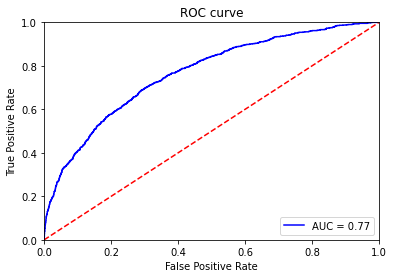

In [21]:
evaluate_model(model1, X_test, y_test)

AUC score: 0.7659056270244646


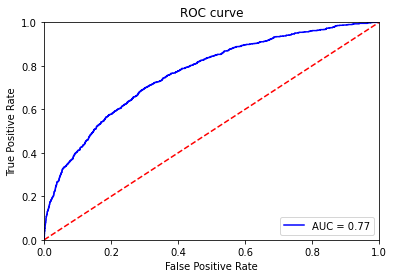

In [22]:
evaluate_model(model2, X_test, y_test)